In [4]:
import pandas as pd
import bioframe as bf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from gtfparse import read_gtf

In [5]:
import gffutils
import pybedtools
from pybedtools.featurefuncs import TSS
from gffutils.helpers import asinterval
import bioframe as bf
from gtfparse import read_gtf

# Replicating relationship with distal enhancers using Nora's DE Data

***Purpose:*** Because we have been able to replicate some results using the DESeq DE genes (Fig 6B: CTCF-binding patterns around the TSS), but not the distal enhancer binding (Fig 6D), I want to re-visit it to follow the process with the data from the original paper in order to replicate their findings.

The original code used:
https://gist.github.com/golobor/66ddc479c460ec128e85b58ba6ec2f91#file-2015-11-23-ctcf-nora-expression-genes-ipynb 

In [208]:
# importing reference tables and data outputs for the RNA-seq analysis

# DE results reported by paper (FPKM)
fpkm = pd.read_csv("/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/supplementary/supplement-10_RNA_seq_FPKM.csv", index_col=0)

tss_df = read_gtf("/project/fudenber_735/genomes/mm9/RefSeq/tsses_from_mm9.refGene.gtf")


/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_name']


In [209]:
# cleaning out less-well defined chromosome numbers
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('NT_'))]
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('MT'))]

# rename column to chrom to match bedframe/bioframe format
tss_df = tss_df.rename(columns= {"seqname" : "chrom"})

In [210]:
# # To extract the coordinates from the DE table into bedframe format 
# (for now, keeping them in there)
#fpkm[['chrom', 'start', 'end']] = fpkm['locus'].str.split(':|-', expand=True)

In [211]:
# Assigning tsses to the fpkm DE table by joining on the gene id
fpkm = fpkm.merge(tss_df.drop_duplicates(['gene_id']), left_on='tracking_id', right_on='gene_id', how='left')

# how many were missing tss_coords?
fpkm.isna().sum()

tracking_id                         0
locus                               0
CTCF-AID_untreated_mean_FPKM        0
CTCF-AID_1day_mean_FPKM             0
CTCF-AID_2days_mean_FPKM            0
CTCF-AID_4days_mean_FPKM            0
CTCF-AID_washoff_mean_FPKM          0
1day.1                              0
2days.1                             0
4days.1                             0
2days_washoff_2days.1               0
WT_untreated_mean_FPKM              0
WT_2days_mean_FPKM                  0
WT_4days_mean_FPKM                  0
chrom                            1063
source                           1063
feature                          1063
start                            1063
end                              1063
score                           24315
strand                           1063
frame                            1063
gene_id                          1063
transcript_id                    1063
gene_name                        1063
dtype: int64

In [212]:
# A few clean-up and filtering steps
print(fpkm.shape)

# remove NA's
fpkm.dropna(subset=['gene_id'], inplace=True)
print(fpkm.shape)

# filter for FPKM > 1.1
fpkm = fpkm[fpkm['CTCF-AID_untreated_mean_FPKM'] > 1.1]
print(fpkm.shape)

(24315, 25)
(23252, 25)
(11039, 25)


In [213]:
fpkm = bf.sanitize_bedframe(fpkm)
print(bf.is_bedframe(fpkm))

fpkm.head(3)

True


,tracking_id,locus,CTCF-AID_untreated_mean_FPKM,CTCF-AID_1day_mean_FPKM,CTCF-AID_2days_mean_FPKM,CTCF-AID_4days_mean_FPKM,CTCF-AID_washoff_mean_FPKM,1day.1,2days.1,4days.1,...,source,feature,start,end,score,strand,frame,gene_id,transcript_id,gene_name
2,0610009B22Rik,chr11:51498886-51502136,69.529333,76.436433,61.336067,38.937500,58.353700,no,no,yes,...,refGene,transcript,51502137,51502137,NaN,-,0,0610009B22Rik,NM_025319,0610009B22Rik
6,0610010F05Rik,chr11:23473775-23533631,4.500230,4.654253,3.784197,3.342397,4.257007,no,no,no,...,refGene,transcript,23533632,23533632,NaN,-,0,0610010F05Rik,NR_156450,0610010F05Rik
7,0610010K14Rik,chr11:70048705-70051416,115.794100,134.728000,124.419633,109.027433,95.227500,no,no,no,...,refGene,transcript,70051417,70051417,NaN,-,0,0610010K14Rik,NM_001177607,0610010K14Rik


In [214]:
# enhancer coordinates from elphege
enhancer_coords = bf.read_table('/project/fudenber_735/collaborations/karissa_2022/features/mm9/mESC_Enhancer_prediction_Chen12_BMCgenomics_mm9.bed',
                               schema='bedGraph',
                               skiprows=1)

# take the top 80%
enhancer_coords['value'] = enhancer_coords['value'].apply(lambda x: x.replace(',', '.')).astype('float')
print(enhancer_coords.tail(3))
enhancer_coords = enhancer_coords[enhancer_coords['value'] >= 0.8]
print(enhancer_coords.tail(3))

       chrom      start        end   value
19197   chr7  106707001  106708000  0.3355
19198   chr4   81950001   81951000  0.3349
19199  chr10   61053001   61054000  0.3338
      chrom      start        end   value
1274   chr1  138467001  138468000  0.8003
1275  chr14   12940001   12941000  0.8000
1276   chr2  135388001  135389000  0.8000


In [215]:
# Assign closest enhancer to each DE gene in the results table
closest_intervals = bf.closest(fpkm, enhancer_coords, suffixes=('_fpkm_tss','_enhancer'))
fpkm['distance_to_enhancer'] = closest_intervals['distance'].replace(0, 1)  # replacing to prevent log-error
fpkm.shape


(11039, 26)

In [216]:
def plot_table(table):

    days = ['1day', '2days', '4days']

    # Generating a subplot for each of the conditions
    num_plots = len(days)
    fig, axs = plt.subplots(1, num_plots, figsize=[num_plots*10, 6])
    fig.suptitle("Genomic separation to enhancers", fontsize=24)
    
    # let's not drop data until we need to
    table = table.dropna(subset=['distance_to_enhancer'])

    for day, ax in zip(days, axs.ravel()):

        up_reg = table.iloc[np.where((table[day + '.1'] == 'yes') & ((table['CTCF-AID_untreated_mean_FPKM'] - table['CTCF-AID_' + day + '_mean_FPKM']) > 0))]
        down_reg = table.iloc[np.where((table[day + '.1'] == 'yes') & ((table['CTCF-AID_untreated_mean_FPKM'] - table['CTCF-AID_' + day + '_mean_FPKM']) < 0))]
        non_reg = table.iloc[np.where(table[day + '.1'] == 'no')]

        # generate y axis: cumulative proportion of genes
        cum_all = np.arange(0, len(non_reg), 1)
        cum_all = cum_all/ len(non_reg)

        # plotting 
        ax.plot(np.log10(non_reg['distance_to_enhancer'].sort_values()), 
                cum_all, 
                color='grey',
                label='Non-regulated',
                linewidth=2)


        # generate y axis: cumulative proportion of genes
        cum_up = np.arange(0, len(up_reg), 1)
        cum_up = cum_up/ len(up_reg)

        ax.plot(np.log10(up_reg['distance_to_enhancer'].sort_values()), 
                cum_up, 
                color='red', 
                label='Up-regulated',
                linewidth=2)

        # generate y axis: cumulative proportion of genes
        cum_down = np.arange(0, len(down_reg), 1)
        cum_down = cum_down/ len(down_reg)

        ax.plot(np.log10(down_reg['distance_to_enhancer'].sort_values()),
                cum_down,
                color='blue',
                label='Down-regulated',
                linewidth=2)

        ax.set_title("Auxin treatment: " + day, fontsize=18)
        ax.set_xlabel("log10 distance from TSS to the closest enhancer", fontsize=14)
        ax.set_ylabel("cumulative portion of genes", fontsize=14)
        ax.set_xlim([2, 7])


    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, fontsize=14)
    plt.show()
    

In [217]:
print(len(fpkm))
print('no closest enhancer found: ', fpkm['distance_to_enhancer'].isna().sum())
print('closest enhancer over 1000 bp away: ', len(fpkm[fpkm['distance_to_enhancer'] > 1000]))
print('closest enhancer over 10000 bp away: ',len(fpkm[fpkm['distance_to_enhancer'] > 10000]))
print('closest enhancer over 100000 bp away: ',len(fpkm[fpkm['distance_to_enhancer'] > 100000]))

# drop NAs
#fpkm.dropna(subset=['distance_to_enhancer'], inplace=True)

11039
no closest enhancer found:  6451
closest enhancer over 1000 bp away:  4573
closest enhancer over 10000 bp away:  4471
closest enhancer over 100000 bp away:  3952


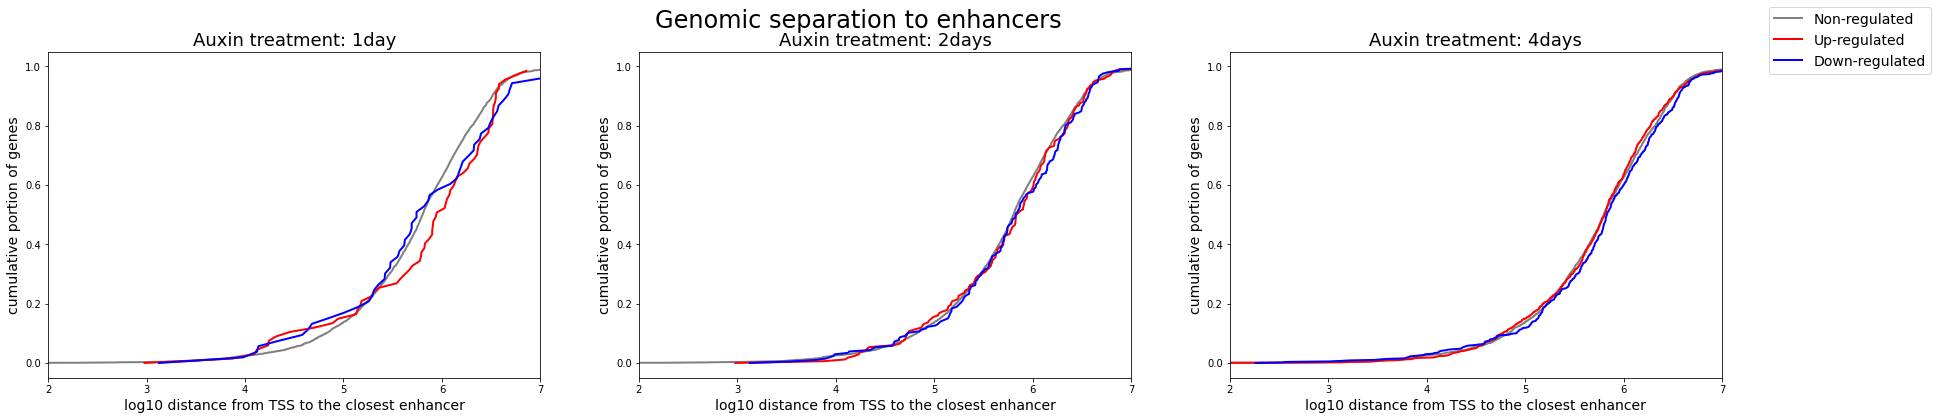

In [218]:
plot_table(fpkm)

In [219]:
# filter for high expression across all conditions ?? 
print(fpkm.shape)
fpkm_xtra_filter = fpkm[fpkm['CTCF-AID_1day_mean_FPKM'] > 1.1]
fpkm_xtra_filter = fpkm_xtra_filter[fpkm_xtra_filter['CTCF-AID_2days_mean_FPKM'] > 1.1]
fpkm_xtra_filter = fpkm_xtra_filter[fpkm_xtra_filter['CTCF-AID_4days_mean_FPKM'] > 1.1]
print(fpkm_xtra_filter.shape)

(11039, 26)
(10561, 26)


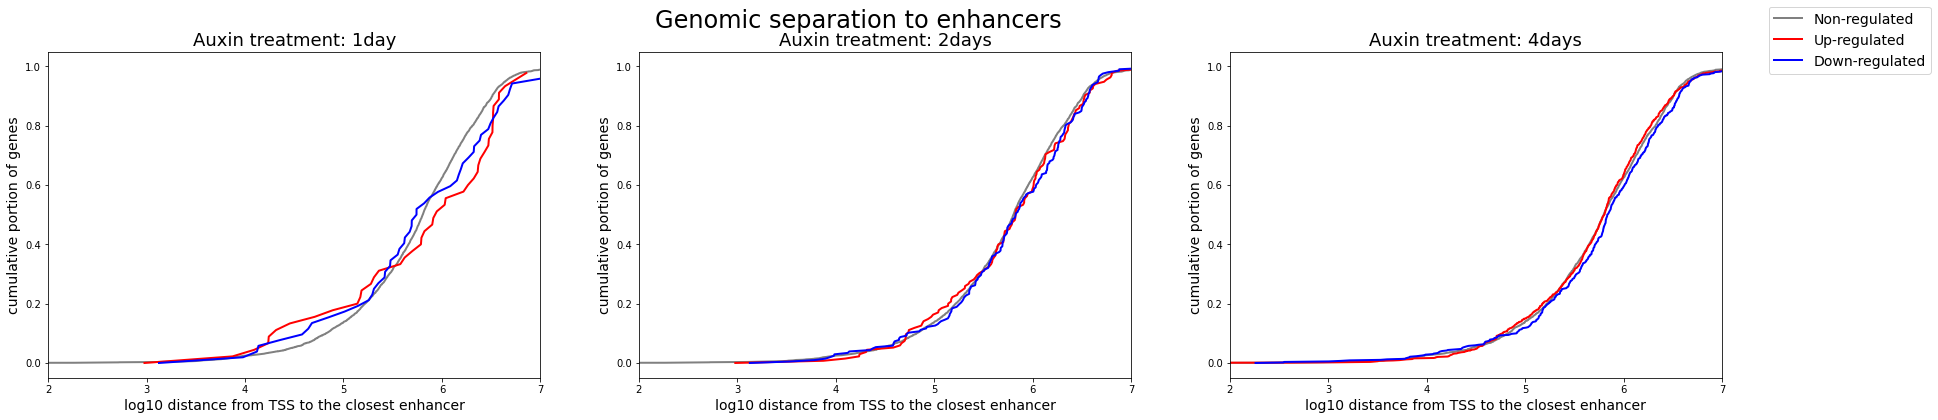

In [220]:
plot_table(fpkm_xtra_filter)

# Using Super-enhancers

In [221]:
# Super-enhancers from whyte 2013
enhancers = pd.read_excel('/project/fudenber_735/collaborations/karissa_2022/features/mm9/NIHMS465689-supplement-02.xls', 
                       sheet_name='Supplemental_Table_S1',
                       header=2)


In [222]:
super_enhancer_coords = enhancers.iloc[np.where(enhancers['isSuper'] == 'YES')]

In [223]:
super_enhancer_coords = bf.sanitize_bedframe(super_enhancer_coords)

In [224]:
# Assign closest enhancer to each DE gene in the results table
closest_super_intervals = bf.closest(fpkm, super_enhancer_coords, suffixes=('_fpkm_tss','_enh'))
fpkm['distance_to_super_enhancer'] = closest_super_intervals['distance'].replace(0, 1)  # replacing to prevent log-error

In [225]:
closest_super_intervals.head(3)

,tracking_id_fpkm_tss,locus_fpkm_tss,CTCF-AID_untreated_mean_FPKM_fpkm_tss,CTCF-AID_1day_mean_FPKM_fpkm_tss,CTCF-AID_2days_mean_FPKM_fpkm_tss,CTCF-AID_4days_mean_FPKM_fpkm_tss,CTCF-AID_washoff_mean_FPKM_fpkm_tss,1day.1_fpkm_tss,2days.1_fpkm_tss,4days.1_fpkm_tss,...,Oct4_enh,Sox2_enh,Nanog_enh,Klf4_enh,Esrrb_enh,H3K27ac_enh,Med1_enh,H3K4me1_enh,DNase_enh,distance
0,1700019A02Rik,chr1:53215420-53244461,3.697807,5.763653,5.039860,1.857677,2.705663,no,no,yes,...,11539.8528,15173.2224,19694.7072,2944.0768,6280.7808,14611.2512,18349.9904,8017.4976,15307.4432,16199051
1,1700019D03Rik,chr1:52981970-53009684,30.405000,34.449967,25.315333,13.278820,25.999033,no,no,yes,...,11539.8528,15173.2224,19694.7072,2944.0768,6280.7808,14611.2512,18349.9904,8017.4976,15307.4432,15964274
2,1700066M21Rik,chr1:57434463-57442266,2.707043,3.882730,3.457807,2.869737,3.183190,no,no,no,...,896.8176,1199.1792,1952.9256,1438.3008,3196.5216,3566.6616,7057.7328,841.5384,1290.7656,14826065


In [226]:
fpkm.head(3)

,tracking_id,locus,CTCF-AID_untreated_mean_FPKM,CTCF-AID_1day_mean_FPKM,CTCF-AID_2days_mean_FPKM,CTCF-AID_4days_mean_FPKM,CTCF-AID_washoff_mean_FPKM,1day.1,2days.1,4days.1,...,start,end,score,strand,frame,gene_id,transcript_id,gene_name,distance_to_enhancer,distance_to_super_enhancer
2,0610009B22Rik,chr11:51498886-51502136,69.529333,76.436433,61.336067,38.937500,58.353700,no,no,yes,...,51502137,51502137,NaN,-,0,0610009B22Rik,NM_025319,0610009B22Rik,679463,14826065
6,0610010F05Rik,chr11:23473775-23533631,4.500230,4.654253,3.784197,3.342397,4.257007,no,no,no,...,23533632,23533632,NaN,-,0,0610010F05Rik,NR_156450,0610010F05Rik,9369,7400396
7,0610010K14Rik,chr11:70048705-70051416,115.794100,134.728000,124.419633,109.027433,95.227500,no,no,no,...,70051417,70051417,NaN,-,0,0610010K14Rik,NM_001177607,0610010K14Rik,721763,721732


In [227]:
print(len(fpkm))
print('no closest enhancer found: ', fpkm['distance_to_super_enhancer'].isna().sum())
print('closest enhancer over 1000 bp away: ', len(fpkm[fpkm['distance_to_super_enhancer'] > 1000]))
print('closest enhancer over 10000 bp away: ',len(fpkm[fpkm['distance_to_super_enhancer'] > 10000]))
print('closest enhancer over 100000 bp away: ',len(fpkm[fpkm['distance_to_super_enhancer'] > 100000]))

11039
no closest enhancer found:  6451
closest enhancer over 1000 bp away:  4562
closest enhancer over 10000 bp away:  4538
closest enhancer over 100000 bp away:  4367


In [230]:
# These numbers are so similar to the above, checking to see and make sure there's not some copy-bug
print(len(fpkm[fpkm['distance_to_enhancer'] != fpkm['distance_to_super_enhancer']]))
fpkm[fpkm['distance_to_enhancer'] != fpkm['distance_to_super_enhancer']]

4587


,tracking_id,locus,CTCF-AID_untreated_mean_FPKM,CTCF-AID_1day_mean_FPKM,CTCF-AID_2days_mean_FPKM,CTCF-AID_4days_mean_FPKM,CTCF-AID_washoff_mean_FPKM,1day.1,2days.1,4days.1,...,start,end,score,strand,frame,gene_id,transcript_id,gene_name,distance_to_enhancer,distance_to_super_enhancer
2,0610009B22Rik,chr11:51498886-51502136,69.529333,76.436433,61.336067,38.937500,58.353700,no,no,yes,...,51502137,51502137,NaN,-,0,0610009B22Rik,NM_025319,0610009B22Rik,679463,14826065
6,0610010F05Rik,chr11:23473775-23533631,4.500230,4.654253,3.784197,3.342397,4.257007,no,no,no,...,23533632,23533632,NaN,-,0,0610010F05Rik,NR_156450,0610010F05Rik,9369,7400396
7,0610010K14Rik,chr11:70048705-70051416,115.794100,134.728000,124.419633,109.027433,95.227500,no,no,no,...,70051417,70051417,NaN,-,0,0610010K14Rik,NM_001177607,0610010K14Rik,721763,721732
9,0610012G03Rik,chr16:31947136-31948607,34.492833,40.396067,36.419533,30.946500,30.611233,no,no,no,...,31948592,31948592,NaN,-,0,0610012G03Rik,NM_134107,0610012G03Rik,1041984,1600963
10,0610030E20Rik,chr6:72297310-72303154,3.961530,4.223233,4.699287,5.407897,4.271537,no,no,no,...,72297310,72297310,NaN,+,0,0610030E20Rik,NM_026696,0610030E20Rik,720662,11037821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11010,Kcnc3,chr7:51846255-51860121,3.498093,3.435570,3.385340,2.837740,2.775633,no,no,no,...,51846255,51846255,NaN,+,0,Kcnc3,NM_001290682,Kcnc3,15336635,22645525
11012,Kcnd1,chrX:7400884-7415404,3.142177,3.416663,3.073463,3.011630,2.764717,no,no,no,...,7400884,7400884,NaN,+,0,Kcnd1,NM_008423,Kcnd1,74016,112078
11027,Kcnh2,chr5:23825406-23857422,3.456817,4.166610,3.953297,3.362287,3.198297,no,no,no,...,23857423,23857423,NaN,-,0,Kcnh2,NM_013569,Kcnh2,4140121,4536751
11035,Kcnip2,chr19:45866835-45890553,1.652680,1.477897,1.308110,0.709878,1.128082,no,no,yes,...,45890554,45890554,NaN,-,0,Kcnip2,NM_030716,Kcnip2,61747,48501144


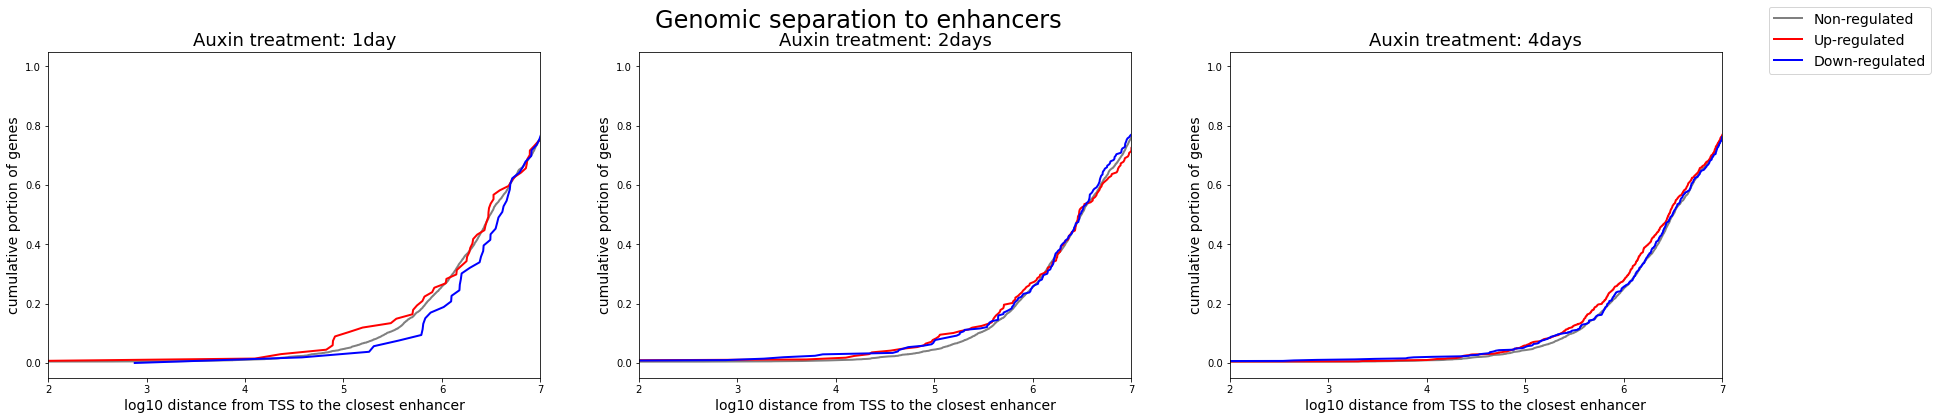

In [232]:
plot_table(fpkm.drop(columns=['distance_to_enhancer']).rename(columns={'distance_to_super_enhancer' : 'distance_to_enhancer'}))

In [25]:
tss_df

,chrom,source,feature,start,end,score,strand,frame,gene_id,transcript_id,...,transcript_name,level,transcript_support_level,mgi_id,tag,havana_gene,havana_transcript,protein_id,ccdsid,ont
0,chrchr1,HAVANA,transcript,3073252,3073252,NaN,+,0,ENSMUSG00000102693.1,ENSMUST00000193812.1,...,4933401J01Rik-201,2,NA,MGI:1918292,basic,OTTMUSG00000049935.1,OTTMUST00000127109.1,,,
1,chrchr1,ENSEMBL,transcript,3102015,3102015,NaN,+,0,ENSMUSG00000064842.1,ENSMUST00000082908.1,...,Gm26206-201,3,NA,MGI:5455983,basic,,,,,
2,chrchr1,HAVANA,transcript,3216345,3216345,NaN,-,0,ENSMUSG00000051951.5,ENSMUST00000162897.1,...,Xkr4-203,2,1,MGI:3528744,,OTTMUSG00000026353.2,OTTMUST00000086625.1,,,
3,chrchr1,HAVANA,transcript,3215633,3215633,NaN,-,0,ENSMUSG00000051951.5,ENSMUST00000159265.1,...,Xkr4-202,2,1,MGI:3528744,,OTTMUSG00000026353.2,OTTMUST00000086624.1,,,
4,chrchr1,HAVANA,transcript,3671499,3671499,NaN,-,0,ENSMUSG00000051951.5,ENSMUST00000070533.4,...,Xkr4-201,2,1,MGI:3528744,"basic,appris_principal_1,CCDS",OTTMUSG00000026353.2,OTTMUST00000065166.1,ENSMUSP00000070648.4,CCDS14803.1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142441,chrJH584299.1,ENSEMBL,transcript,913084,913084,NaN,-,0,ENSMUSG00000095475.1,ENSMUST00000180208.1,...,AC133095.2-201,3,1,,basic,,,ENSMUSP00000137110.1,,
142442,chrJH584299.1,ENSEMBL,transcript,921941,921941,NaN,+,0,ENSMUSG00000094855.1,ENSMUST00000178327.1,...,AC133095.1-201,3,5,,basic,,,ENSMUSP00000137276.1,,
142443,chrJH584303.1,ENSEMBL,transcript,81606,81606,NaN,+,0,ENSMUSG00000095019.1,ENSMUST00000178569.1,...,AC234645.1-201,3,NA,,basic,,,ENSMUSP00000136543.1,,
142444,chrJH584304.1,ENSEMBL,transcript,59668,59668,NaN,-,0,ENSMUSG00000095041.7,ENSMUST00000179505.7,...,AC149090.1-201,3,1,,basic,,,ENSMUSP00000136028.1,,


In [26]:
# Displaying last 5 --> the original data was ordered descending by 'value'
enhancer_coords.tail(5)

,chrom,start,end,name,score
1272,chr18,77142262,77143261,chr18:77381002-77382000,1
1273,chr9,78374194,78375193,chr9:78222002-78223000,1
1274,chr1,136570424,136571423,chr1:138467002-138468000,1
1275,chr14,12107487,12108486,chr14:12940002-12941000,1
1276,chr2,135562265,135563264,chr2:135388002-135389000,1
